In [1]:
import os
import sys
from tqdm import tqdm
from datetime import datetime
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from sklearn.model_selection import TimeSeriesSplit

import torch
import torch.nn as nn
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch_geometric.data import Data, Batch

In [2]:
# Create submission folder if it doesn't exist
submission_dir = './submission'
os.makedirs(submission_dir, exist_ok=True)

# Uncomment the following block ONLY if you wish to inspect file paths in a Kaggle-like directory structure.
# On your local system, you likely have the files in your local folder so this is not needed.
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))


# Data Loading for Local Environment
# Files are assumed to be in:
# ./cse-251-b-2025/train.npz
# ./cse-251-b-2025/test_input.npz

train_file = np.load("./cse-251-b-2025/train.npz")
train_data = train_file['data']
print("train_data's shape:", train_data.shape)  # Expected shape: (10000, 50, 110, 6)

test_file = np.load("./cse-251-b-2025/test_input.npz")
test_data = test_file['data']
print("test_data's shape:", test_data.shape)    # Expected shape: (2100, 50, 50, 6)

train_data's shape: (10000, 50, 110, 6)
test_data's shape: (2100, 50, 50, 6)


# Visualization: 

In [3]:
# Run visualizations?
run_visualizations: bool = False

# From data loading notebook
def plot_one_training_scene(idx: int = 0):
    # Plot trajectories from one training scene (static plot)
    data_matrix = train_data[idx]

    plt.figure(figsize=(8, 8))
    for agent in range(data_matrix.shape[idx]):
        xs = data_matrix[agent, :, 0]
        ys = data_matrix[agent, :, 1]
        # Remove zeros (padding)
        xs = xs[xs != 0]
        ys = ys[ys != 0]
        plt.plot(xs, ys, alpha=0.7)
    plt.title("Trajectories from one training scene")
    plt.xlabel("x-coordinate")
    plt.ylabel("y-coordinate")
    plt.show()

# Create an animated gif for one training scene (exact code provided on kaggle)
def make_gif(data_matrix, name='example'):
    cmap = None
    if sys.version_info.minor <= 7:
        cmap = plt.cm.get_cmap("viridis", 50)
    else:
        cmap = plt.get_cmap("viridis", 50)

    fig, ax = plt.subplots(figsize=(10, 10))
    # Function to update plot for each frame
    def update(frame):
        ax.clear()
        # Get data for current timestep
        for i in range(1, data_matrix.shape[0]):
            x = data_matrix[i, frame, 0]
            y = data_matrix[i, frame, 1]
            if x != 0 and y != 0:
                xs = data_matrix[i, :frame+1, 0]  # Include current frame
                ys = data_matrix[i, :frame+1, 1]  # Include current frame
                # trim all zeros
                mask = (xs != 0) & (ys != 0)  # Only keep points where both x and y are non-zero
                xs = xs[mask]
                ys = ys[mask]
                # Only plot if we have points to plot
                if len(xs) > 0 and len(ys) > 0:
                    color = cmap(i)
                    ax.plot(xs, ys, alpha=0.9, color=color)
                    ax.scatter(x, y, s=80, color=color)
        ax.plot(data_matrix[0, :frame, 0], data_matrix[0, :frame, 1],
                color='tab:orange', label='Ego Vehicle')
        ax.scatter(data_matrix[0, frame, 0], data_matrix[0, frame, 1],
                   s=80, color='tab:orange')
        # Set title with timestep
        ax.set_title(f'Timestep {frame}')
        # Set consistent axis limits
        ax.set_xlim(data_matrix[:,:,0][data_matrix[:,:,0] != 0].min() - 10, 
                    data_matrix[:,:,0][data_matrix[:,:,0] != 0].max() + 10)
        ax.set_ylim(data_matrix[:,:,1][data_matrix[:,:,1] != 0].min() - 10, 
                    data_matrix[:,:,1][data_matrix[:,:,1] != 0].max() + 10)
        ax.legend()
        return ax.collections + ax.lines

    # Create animation
    anim = animation.FuncAnimation(fig, update, frames=list(range(0, data_matrix.shape[1], 3)),
                                   interval=100, blit=True)
    # Save as GIF
    anim.save(f'trajectory_visualization_{name}.gif', writer='pillow')
    plt.close()

if run_visualizations:
    plot_one_training_scene(0)
    make_gif(train_data[0], 'index0')

# Constant velocity from test set
Untouched from original data loading notebook.

In [4]:
# Run constant velocity model (Kaggle score of ~50)?
run_constant_velocity_model: bool = False

if run_constant_velocity_model:
    # Compute the velocity differences for the ego vehicle (agent index 0)
    velocity_diff = test_data[..., 1:, :2] - test_data[..., :-1, :2]
    print("Velocity difference shape:", velocity_diff.shape)

    # Compute average velocity for the ego vehicle (index 0) in each scene
    constant_vel = np.mean(velocity_diff[:, 0, :, :], axis=1)
    print("Constant velocity shape:", constant_vel.shape)

    # Generate predictions for 60 future time steps based on constant velocity
    pred_y_const = np.zeros((test_data.shape[0], 60, 2))
    starting_point = test_data[:, 0, -1, :2]  # Last observed position of ego vehicle

    for t in range(60):
        pred_y_const[:, t, :] = starting_point + (t + 1) * constant_vel

    # Reshape predictions to submission format: (2100, 60, 2) -> (12600, 2)
    pred_output_const = pred_y_const.reshape(-1, 2)
    output_df_const = pd.DataFrame(pred_output_const, columns=['x', 'y'])
    output_df_const.index.name = 'index'
    # Save output in the submission folder
    constant_vel_path = os.path.join(submission_dir, 'constant_vel_submission.csv')
    output_df_const.to_csv(constant_vel_path)
    print(f"Constant velocity submission saved locally as '{constant_vel_path}'.")

# Our Work

In [5]:
# MLP model with residual blocks: ineffective for TimeSeries data
class BasicMLP(nn.Module):
    def __init__(self, input_features, output_features):
        super().__init__()

        # Lazy layers infer the input size instead of having to explicitly pass it in
        # Backbone: linear -> BatchNorm -> PReLU -> Dropout
        self.net = nn.Sequential(
            nn.Linear(input_features, 1024),
            nn.BatchNorm1d(1024),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(1024, 512),
            nn.BatchNorm1d(512),
            nn.PReLU(),
            nn.Dropout(0.2),

            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.PReLU(),
            nn.Dropout(0.2),
        ) # Note: residual width must match the last width of the net

        # Residual block added to avoid vanishing gradient issue
        self.residual = nn.Sequential(
            nn.LazyLinear(256),
            nn.ReLU(),
            nn.LazyLinear(256),
        )

        # Infer last input shape, then do final projection (60*2)
        self.head = nn.LazyLinear(output_features)

    def forward(self, x):
        # Original forward loop
        # # (batch, 50, 50, 6) or flattened already
        # x = x.view(x.size(0), -1)
        # h = self.net(x) #(batch, 256)
        # h = h + self.residual(h)  # residual skip
        # return self.head(h) #(batch, 120)

        # Taken from milestone notebook (tensor format)
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        x = x.reshape(-1, 50 * 50 * 6)
        x = self.net(x)
        x = x + self.residual(x)
        x = self.head(x)
        return x.view(-1, 60, 2)

In [6]:
# Base LSTM given to us in the milestone notebook
class BaseLSTM(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(BaseLSTM, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        out = self.fc(lstm_out[:, -1, :])
        return out.view(-1, 60, 2)

In [7]:
# Multi agent scene context model
class SceneContextModel(nn.Module):
    def __init__(self, hidden_dim=128):
        super().__init__()
        self.agent_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.ego_encoder = nn.Sequential(
            nn.Linear(50 * 6, hidden_dim),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(2 * hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, 60 * 2)
        )

    def forward(self, x_flat):
        # x = data.x
        # x = x[:, :, :, :2] # (batch, 50, 50, 2)
        # x = x.reshape(-1, 50 * 50 * 6)
        # x = self.mlp(x)
        # return x.view(-1, 60, 2)
        # In case you passed in a DataBatch
        if not isinstance(x_flat, torch.Tensor):
            x_flat = x_flat.x

        B = x_flat.size(0)
        x = x_flat.view(B, 50, 50, 6) #(B, agents, timesteps, features)
        x_agents = x.view(B, 50, -1)  #(B, 50, 300)
        agent_feats = self.agent_encoder(x_agents) #(B, 50, hidden_dim)
        scene_context = agent_feats.mean(dim=1) #(B, hidden_dim)

        ego_input = x[:, 0, :, :].reshape(B, -1) #(B, 300)
        ego_feat = self.ego_encoder(ego_input) #(B, hidden_dim)

        combined = torch.cat([ego_feat, scene_context], dim=1)

        out = self.decoder(combined) #(B, 120)
        return out.view(-1, 60, 2)

In [8]:
# Extended from the base LSTM model
class LSTMWithMLP(nn.Module):
    def __init__(self, input_dim:int =6, hidden_dim:int =128, output_dim:int =60 * 2, dropout:float = 0):
        super(LSTMWithMLP, self).__init__()
        self.lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True, dropout=dropout)
        self.net = nn.Sequential(
            nn.Linear(hidden_dim, 128),
            nn.BatchNorm1d(128),
            nn.LeakyReLU(),
        )
        self.fc = nn.Linear(128, output_dim)

    def forward(self, x):
        # In case you passed in a DataBatch
        if not isinstance(x, torch.Tensor):
            x = x.x

        x= x.reshape(-1, 50, 50, 6)  # (batch_size, num_agents, seq_len, input_dim)
        x = x[:, 0, :, :] # Only Consider ego agent index 0

        lstm_out, _ = self.lstm(x)
        # lstm_out is of shape (batch_size, seq_len, hidden_dim) and we want the last time step output
        x = self.net(lstm_out[:, -1, :])
        x = self.fc(x)
        return x.view(-1, 60, 2)

# Preparing data

`TrajectoryDataset*` are taken from the milestone notebook.

In [9]:
class TrajectoryDatasetTrain(Dataset):
    def __init__(self, data, scale=10.0, augment=True):
        """
        data: Shape (N, 50, 110, 6) Training data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        augment: Whether to apply data augmentation (only for training)
        """
        self.data = data
        self.scale = scale
        self.augment = augment

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        scene = self.data[idx]
        # Getting 50 historical timestamps and 60 future timestamps
        hist = scene[:, :50, :].copy()    # (agents=50, time_seq=50, 6)
        future = torch.tensor(scene[0, 50:, :2].copy(), dtype=torch.float32)  # (60, 2)
        
        # Data augmentation(only for training)
        if self.augment:
            if np.random.rand() < 0.5:
                theta = np.random.uniform(-np.pi, np.pi)
                R = np.array([[np.cos(theta), -np.sin(theta)],
                              [np.sin(theta),  np.cos(theta)]], dtype=np.float32)
                # Rotate the historical trajectory and future trajectory
                hist[..., :2] = hist[..., :2] @ R
                hist[..., 2:4] = hist[..., 2:4] @ R
                # future = future @ R gives DeprecationWarning: future a torch.Tensor
                future = torch.from_numpy(np.dot(future.numpy(), R)) 
            if np.random.rand() < 0.5:
                hist[..., 0] *= -1
                hist[..., 2] *= -1
                future[:, 0] *= -1

        # Use the last timeframe of the historical trajectory as the origin
        origin = hist[0, 49, :2].copy()  # (2,)
        hist[..., :2] = hist[..., :2] - origin
        # future = future - origin -> same DeprecationWarning
        future = torch.from_numpy(future.numpy() - origin)

        # Normalize the historical trajectory and future trajectory
        hist[..., :4] = hist[..., :4] / self.scale
        future = future / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            y=future.type(torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )

        return data_item
    

class TrajectoryDatasetTest(Dataset):
    def __init__(self, data, scale=10.0):
        """
        data: Shape (N, 50, 110, 6) Testing data
        scale: Scale for normalization (suggested to use 10.0 for Argoverse 2 data)
        """
        self.data = data
        self.scale = scale

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Testing data only contains historical trajectory
        scene = self.data[idx]  # (50, 50, 6)
        hist = scene.copy()
        
        origin = hist[0, 49, :2].copy()
        hist[..., :2] = hist[..., :2] - origin
        hist[..., :4] = hist[..., :4] / self.scale

        data_item = Data(
            x=torch.tensor(hist, dtype=torch.float32),
            origin=torch.tensor(origin, dtype=torch.float32).unsqueeze(0),
            scale=torch.tensor(self.scale, dtype=torch.float32),
        )
        return data_item

# Training loop

Change which model is used at the `model = ...(input_features, output_features)` line.

Change which optimizer is used at the `optimizer = optim...` line.

Do **NOT** change the `criterion`, as MSE is stated in the Data tab of the competition.

In [10]:
# Taken from milestone notebook
# Set device for training speedup
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using Apple Silicon GPU")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print("Using CUDA GPU")
else:
    device = torch.device('cpu')
    print("Using CPU")

Using CPU


In [11]:
# Functions to save and load the model (should correspond to what was trained!)
def save_model(model, path="our_model.pth"):
    torch.save(model.state_dict(), path)
    print(f"Model saved to {path}")


def load_model(model_instance, path="our_model.pth"):
    loaded_model = model_instance
    loaded_model.load_state_dict(torch.load(path))
    loaded_model.eval()
    return loaded_model


# Example usage:
# save_model(trained_model)
# model = load_model()

In [12]:
def get_timestamp() -> str:
    return datetime.now().strftime("%Y-%m-%d_%I-%M%p")

In [ ]:
# Calculate number of input features after flattening and number of output features
# Note: LSTM models take features in different dimensions
input_features:int = 50 * 50 * 6   # 50 agents, 50 time steps, 6 dimensions each (15000 input features)
output_features:int = 60 * 2       # 60 future time steps, 2 dimensions (x, y) (120 output features)

# Hyperparameters
batch_size: int = 32
num_folds: int = 4
early_stopping_patience: int = 30
early_stopping_threshold: float = 1e-4
epochs: int = 250
starting_lr: float = 1e-2
scale: float = 7.0
weight_decay: float = 1e-2

lstm_hidden_dim: int = 256

# IMPORTANT! To change which model is used: comment/uncomment below
# Easily swap models by changing what is returned (called in training and test to avoid conflicts)
def get_model():
    return BasicMLP(input_features, output_features).to(device)
    # return BaseLSTM(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)
    # return SceneContextModel(hidden_dim=864).to(device)
    # return LSTMWithMLP(input_dim=6, hidden_dim=lstm_hidden_dim, output_dim=output_features).to(device)

SEED: int = 42
torch.manual_seed(SEED)
np.random.seed(SEED)

def train_model(full_training_data: np.ndarray, 
                batch_size:int = 64, epochs:int = 10, num_folds:int = 5,
                early_stopping_patience:int = 5, early_stopping_threshold:float = 1e-3):
    global starting_lr, gamma, scale, lstm_hidden_dim, output_features, weight_decay

    # Time series data needs to keep its data in relative order, so no shuffling can occur
    #   like in regular KFold cross validation
    splitter = TimeSeriesSplit(n_splits=num_folds)

    # Perform cross-validation, the best model will be saved as "best_model.pt" to be loaded in later
    overall_best_val_loss = float("inf")

    # Resources used:
    # Project milestone notebook
    # https://github.com/christianversloot/machine-learning-articles/blob/main/how-to-use-k-fold-cross-validation-with-pytorch.md
    # https://www.geeksforgeeks.org/time-series-cross-validation/
    for fold_i, (train_idx, val_idx) in enumerate(splitter.split(full_training_data)):
        print(f"\nFOLD {fold_i + 1}/{num_folds} ==================================")

        # Create the model, loss criterion, and optimizer (reset per fold, to find the best model)
        # If you change the model here, ensure its the same in the test loop!
        # DO NOT CHANGE CRITERION
        criterion = nn.MSELoss()

        model = get_model()
        optimizer = optim.AdamW(model.parameters(), lr=starting_lr, weight_decay=weight_decay)
        schedulers: list[lr_scheduler.LRScheduler] =[
            lr_scheduler.ExponentialLR(optimizer, gamma=0.995),
            lr_scheduler.MultiStepLR(
                optimizer,
                milestones= list(range(25, epochs, 25)),
                gamma=0.75,
            ),
            # lr_scheduler.MultiStepLR(
            #     optimizer,
            #     milestones= list(range(100, epochs, 100)),
            #     gamma=0.5,
            # ),
            lr_scheduler.CosineAnnealingLR(
                optimizer, 
                T_max= int(epochs * 0.9),
                eta_min=1e-5
            ),
        ]

        # Prepare data from this fold
        train_fold: np.ndarray = full_training_data[train_idx]
        val_fold: np.ndarray = full_training_data[val_idx]
        collate_func = None     # Optional for DataLoader, taken from milestone notebook
        if not isinstance(model, SceneContextModel):
            # LSTM can handle the timeseries data directly
            # TrajectoryDataset expects numpy arrays
            collate_func = lambda x: Batch.from_data_list(x)
            train_dataset = TrajectoryDatasetTrain(train_fold, scale=scale, augment=True)
            val_dataset = TrajectoryDatasetTrain(val_fold, scale=scale, augment=False)
        else:
            train_x: np.ndarray = train_fold[..., :50, :]
            train_y: np.ndarray = train_fold[:, 0, 50:, :2]
            X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
            y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
            train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

            val_x: np.ndarray = val_fold[..., :50, :]
            val_y: np.ndarray = val_fold[:, 0, 50:, :2]
            X_val_tensor = torch.FloatTensor(val_x).reshape((-1, input_features))
            y_val_tensor = torch.FloatTensor(val_y).reshape((-1, output_features))
            val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

        train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_func)
        val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

        best_val_loss: float = float("inf")
        no_improvement: int = 0

        # Training and validation loops are taken from the milestone notebook,
        #   with modifications to allow for different data loading shapes      
        for epoch in tqdm(range(epochs), desc="Epoch", unit="epoch"):
            # Training loop
            model.train()
            train_loss = 0
            for batch in train_dataloader:
                batch_x = None
                batch_y = None
                if isinstance(batch, tuple) or isinstance(batch, list):
                    batch_x, batch_y = batch
                    batch_y = batch_y.view(-1, 60, 2)
                else: # DataBatch type
                    batch = batch.to(device)
                    batch_x = batch.x
                    batch_y = batch.y.view(batch.num_graphs, 60, 2)

                optimizer.zero_grad()
                outputs = model(batch_x)
                loss = criterion(outputs, batch_y)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=2.0)
                optimizer.step()
                train_loss += loss.item()

            # Validation loop
            model.eval()
            val_loss = 0
            val_mae = 0
            val_mse = 0
            with torch.no_grad():
                for batch in val_dataloader:
                    batch_x = None
                    batch_y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        batch_x, batch_y = batch
                        batch_y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        batch = batch.to(device)
                        batch_x = batch.x
                        batch_y = batch.y.view(batch.num_graphs, 60, 2)

                    pred = model(batch_x)
                    val_loss += criterion(pred, batch_y).item()

                    # show MAE and MSE with unnormalized data
                    y = None
                    if isinstance(batch, tuple) or isinstance(batch, list):
                        y = batch_y.view(-1, 60, 2)
                    else: # DataBatch type
                        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                        y = batch_y * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
                    val_mae += nn.L1Loss()(pred, y).item()
                    val_mse += nn.MSELoss()(pred, y).item()

            train_loss /= len(train_dataloader)
            val_loss /= len(val_dataloader)
            val_mae /= len(val_dataloader)
            val_mse /= len(val_dataloader)

            if (epoch + 1) % 5 == 0:
                tqdm.write(f"Epoch {(epoch + 1):03d} | Learning rate {optimizer.param_groups[0]['lr']:.6f} | train normalized MSE {train_loss:8.4f} | val normalized MSE {val_loss:8.4f}, | val MAE {val_mae:8.4f} | val MSE {val_mse:8.4f}")

            if val_loss < best_val_loss - early_stopping_threshold:
                best_val_loss = val_loss
                no_improvement = 0

                # Better than the overall seen so far?
                if best_val_loss < overall_best_val_loss:
                    overall_best_val_loss = best_val_loss
                    torch.save(model.state_dict(), "best_model.pt")
            else:
                no_improvement += 1
                if no_improvement >= early_stopping_patience:
                    print(f"==== EARLY STOP at epoch {(epoch + 1):03d}")
                    break

            for sched in schedulers:
                sched.step()


# Load in the model saved during testing to use on X_test
# Mostly taken from milestone notebook
def predict(X_test: np.ndarray, best_model_path: str = "best_model.pt"):
    global scale, batch_size, lstm_hidden_dim, output_features

    # Ensure this aligns with the trained model!
    best_model = torch.load(best_model_path)
    model = get_model()
    model.load_state_dict(best_model)
    model.eval()

    pred_list = []
    with torch.no_grad():
        if not isinstance(model, SceneContextModel): # Using DataBatch type from a DataLoader
            collate_func = lambda x: Batch.from_data_list(x)
            test_dataset = TrajectoryDatasetTest(X_test, scale=scale)
            test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_func)

            for batch in test_loader:
                batch = batch.to(device)
                pred_norm = model(batch.x)

                # Reshape the prediction to (N, 60, 2)
                pred = pred_norm * batch.scale.view(-1,1,1) + batch.origin.unsqueeze(1)
                pred_list.append(pred.cpu().numpy())
        else:
            X_test_tensor = torch.FloatTensor(X_test).reshape((-1, input_features)).to(device)
            pred = model(X_test_tensor).cpu().reshape((-1, 60, 2))
            pred_list.append(pred.numpy())

    # Reshape predictions to match submission format: (2100, 60, 2) -> (12600, 2)
    pred_list = np.concatenate(pred_list, axis=0)  # (N,60,2)
    pred_output = pred_list.reshape(-1, 2)  # (N*60, 2)
    output_df = pd.DataFrame(pred_output, columns=['x', 'y'])
    output_df.index.name = 'index'
    return output_df

# Train the model (tweak batch_size and epochs as needed at top of this block)
# Saved as "best_model.pt" to be loaded in during testing
train_model(train_data, batch_size=batch_size, epochs=epochs, num_folds=num_folds,
            early_stopping_patience=early_stopping_patience,
            early_stopping_threshold=early_stopping_threshold)

# Make predictions on the test set
model_predictions_df = predict(test_data)
assert len(model_predictions_df) == 126000, f"Incorrect number of rows in output, expected 126000, got {len(model_predictions_df)}"

# Save output in the submission foldder, timestamped!
submission_path = os.path.join(submission_dir, f"submission-{get_timestamp()}.csv")
model_predictions_df.to_csv(submission_path)
print(f"Submission saved locally as: '{submission_path}'.")


FOLD 1/4 ==================================


Epoch:   2%|▏         | 5/250 [00:25<20:10,  4.94s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   6.3142 | val normalized MSE   6.3135, | val MAE  10.1092 | val MSE 309.3636


Epoch:   4%|▍         | 10/250 [00:49<19:12,  4.80s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   6.2996 | val normalized MSE   6.3249, | val MAE   9.9789 | val MSE 309.9218


Epoch:   6%|▌         | 15/250 [01:13<19:20,  4.94s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   6.2434 | val normalized MSE   6.3317, | val MAE  10.0190 | val MSE 310.2513


Epoch:   8%|▊         | 20/250 [01:38<19:17,  5.03s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   6.2790 | val normalized MSE   6.3253, | val MAE  10.0114 | val MSE 309.9381


Epoch:  10%|█         | 25/250 [02:04<19:03,  5.08s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   6.2447 | val normalized MSE   6.3453, | val MAE  10.1735 | val MSE 310.9184


Epoch:  12%|█▏        | 30/250 [02:29<18:33,  5.06s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   5.7395 | val normalized MSE   5.9729, | val MAE  10.5157 | val MSE 292.6705


Epoch:  14%|█▍        | 35/250 [02:54<18:11,  5.08s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   5.3862 | val normalized MSE   5.4868, | val MAE   9.9645 | val MSE 268.8518


Epoch:  16%|█▌        | 40/250 [03:20<17:52,  5.11s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   5.0508 | val normalized MSE   5.1643, | val MAE   9.3018 | val MSE 253.0503


Epoch:  18%|█▊        | 45/250 [03:46<17:27,  5.11s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   4.4084 | val normalized MSE   4.5555, | val MAE   8.9936 | val MSE 223.2196


Epoch:  20%|██        | 50/250 [04:11<17:03,  5.12s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   4.3467 | val normalized MSE   4.7042, | val MAE   9.1336 | val MSE 230.5074


Epoch:  22%|██▏       | 55/250 [04:37<17:02,  5.24s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   3.9797 | val normalized MSE   4.1402, | val MAE   8.4957 | val MSE 202.8701


Epoch:  24%|██▍       | 60/250 [05:03<16:20,  5.16s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   3.9036 | val normalized MSE   4.0286, | val MAE   8.2317 | val MSE 197.3992


Epoch:  26%|██▌       | 65/250 [05:29<15:45,  5.11s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   3.7563 | val normalized MSE   3.8955, | val MAE   8.1017 | val MSE 190.8813


Epoch:  28%|██▊       | 70/250 [05:54<15:09,  5.05s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   3.8299 | val normalized MSE   3.8857, | val MAE   8.1557 | val MSE 190.3972


Epoch:  30%|███       | 75/250 [06:20<15:03,  5.16s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   3.5519 | val normalized MSE   3.7474, | val MAE   7.9850 | val MSE 183.6227


Epoch:  32%|███▏      | 80/250 [06:45<14:31,  5.12s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   3.2690 | val normalized MSE   3.4058, | val MAE   7.8419 | val MSE 166.8834


Epoch:  34%|███▍      | 85/250 [07:11<14:13,  5.18s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   3.0257 | val normalized MSE   2.9856, | val MAE   7.1765 | val MSE 146.2931


Epoch:  36%|███▌      | 90/250 [07:37<13:53,  5.21s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   2.6167 | val normalized MSE   2.5507, | val MAE   6.8306 | val MSE 124.9844


Epoch:  38%|███▊      | 95/250 [08:03<13:13,  5.12s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   2.4191 | val normalized MSE   2.4020, | val MAE   6.5474 | val MSE 117.6971


Epoch:  40%|████      | 100/250 [08:29<12:54,  5.16s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   2.1002 | val normalized MSE   2.1940, | val MAE   6.1873 | val MSE 107.5076


Epoch:  42%|████▏     | 105/250 [08:54<12:21,  5.11s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   2.0198 | val normalized MSE   1.9470, | val MAE   5.8127 | val MSE  95.4016


Epoch:  44%|████▍     | 110/250 [09:20<12:04,  5.17s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   1.8845 | val normalized MSE   1.9311, | val MAE   5.7739 | val MSE  94.6237


Epoch:  46%|████▌     | 115/250 [09:46<11:42,  5.20s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   1.8247 | val normalized MSE   1.8808, | val MAE   5.6801 | val MSE  92.1607


Epoch:  48%|████▊     | 120/250 [10:11<11:05,  5.12s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   1.6988 | val normalized MSE   2.0577, | val MAE   6.0940 | val MSE 100.8252


Epoch:  50%|█████     | 125/250 [10:37<10:40,  5.12s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   1.5670 | val normalized MSE   1.8496, | val MAE   5.6321 | val MSE  90.6322


Epoch:  52%|█████▏    | 130/250 [11:03<10:08,  5.07s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   1.5804 | val normalized MSE   1.7964, | val MAE   5.5547 | val MSE  88.0251


Epoch:  54%|█████▍    | 135/250 [11:28<09:46,  5.10s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE   1.5496 | val normalized MSE   1.8031, | val MAE   5.5930 | val MSE  88.3503


Epoch:  56%|█████▌    | 140/250 [11:54<09:15,  5.05s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE   1.4728 | val normalized MSE   1.6574, | val MAE   5.3742 | val MSE  81.2135


Epoch:  58%|█████▊    | 145/250 [12:19<08:53,  5.08s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE   1.4074 | val normalized MSE   1.8756, | val MAE   5.7046 | val MSE  91.9044


Epoch:  60%|██████    | 150/250 [12:44<08:23,  5.04s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE   1.3857 | val normalized MSE   1.6580, | val MAE   5.3268 | val MSE  81.2400


Epoch:  62%|██████▏   | 155/250 [13:09<07:57,  5.03s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE   1.3957 | val normalized MSE   1.6243, | val MAE   5.2547 | val MSE  79.5905


Epoch:  64%|██████▍   | 160/250 [13:35<07:32,  5.03s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE   1.3910 | val normalized MSE   1.6101, | val MAE   5.2404 | val MSE  78.8924


Epoch:  66%|██████▌   | 165/250 [14:00<07:08,  5.04s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE   1.3724 | val normalized MSE   1.5212, | val MAE   5.0891 | val MSE  74.5375


Epoch:  68%|██████▊   | 170/250 [14:25<06:41,  5.02s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE   1.3224 | val normalized MSE   1.5515, | val MAE   5.1328 | val MSE  76.0255


Epoch:  70%|███████   | 175/250 [14:50<06:14,  4.99s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE   1.3795 | val normalized MSE   1.6840, | val MAE   5.3474 | val MSE  82.5177


Epoch:  72%|███████▏  | 180/250 [15:15<05:47,  4.97s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE   1.3570 | val normalized MSE   1.5887, | val MAE   5.1951 | val MSE  77.8471


Epoch:  74%|███████▍  | 185/250 [15:40<05:23,  4.97s/epoch]

Epoch 185 | Learning rate 0.000049 | train normalized MSE   1.3519 | val normalized MSE   1.7862, | val MAE   5.5383 | val MSE  87.5216


Epoch:  76%|███████▌  | 190/250 [16:05<05:00,  5.01s/epoch]

Epoch 190 | Learning rate 0.000039 | train normalized MSE   1.3615 | val normalized MSE   1.5854, | val MAE   5.2057 | val MSE  77.6859


Epoch:  78%|███████▊  | 195/250 [16:30<04:38,  5.07s/epoch]

Epoch 195 | Learning rate 0.000031 | train normalized MSE   1.2986 | val normalized MSE   1.4773, | val MAE   4.9893 | val MSE  72.3855


Epoch:  80%|████████  | 200/250 [16:55<04:11,  5.02s/epoch]

Epoch 200 | Learning rate 0.000024 | train normalized MSE   1.3781 | val normalized MSE   1.7636, | val MAE   5.5353 | val MSE  86.4163


Epoch:  82%|████████▏ | 205/250 [17:20<03:45,  5.01s/epoch]

Epoch 205 | Learning rate 0.000015 | train normalized MSE   1.3640 | val normalized MSE   1.4962, | val MAE   5.0333 | val MSE  73.3148


Epoch:  84%|████████▍ | 210/250 [17:45<03:21,  5.03s/epoch]

Epoch 210 | Learning rate 0.000013 | train normalized MSE   1.3705 | val normalized MSE   1.6009, | val MAE   5.1999 | val MSE  78.4424


Epoch:  86%|████████▌ | 215/250 [18:11<02:58,  5.10s/epoch]

Epoch 215 | Learning rate 0.000011 | train normalized MSE   1.3001 | val normalized MSE   1.4708, | val MAE   4.9838 | val MSE  72.0704


Epoch:  88%|████████▊ | 220/250 [18:36<02:31,  5.04s/epoch]

Epoch 220 | Learning rate 0.000010 | train normalized MSE   1.3088 | val normalized MSE   1.4893, | val MAE   5.0492 | val MSE  72.9749


Epoch:  90%|█████████ | 225/250 [19:01<02:06,  5.07s/epoch]

Epoch 225 | Learning rate 0.000010 | train normalized MSE   1.2988 | val normalized MSE   1.5201, | val MAE   5.1198 | val MSE  74.4864


Epoch:  92%|█████████▏| 230/250 [19:27<01:40,  5.04s/epoch]

Epoch 230 | Learning rate 0.000016 | train normalized MSE   1.2754 | val normalized MSE   1.5545, | val MAE   5.1380 | val MSE  76.1704


Epoch:  94%|█████████▍| 235/250 [19:52<01:16,  5.07s/epoch]

Epoch 235 | Learning rate 0.000038 | train normalized MSE   1.3436 | val normalized MSE   1.5263, | val MAE   5.0850 | val MSE  74.7884


Epoch:  96%|█████████▌| 240/250 [20:17<00:50,  5.07s/epoch]

Epoch 240 | Learning rate 0.000075 | train normalized MSE   1.3482 | val normalized MSE   1.6182, | val MAE   5.2609 | val MSE  79.2908


Epoch:  98%|█████████▊| 244/250 [20:43<00:30,  5.10s/epoch]


Epoch 245 | Learning rate 0.000127 | train normalized MSE   1.3353 | val normalized MSE   1.4813, | val MAE   5.0006 | val MSE  72.5860
==== EARLY STOP at epoch 245

FOLD 2/4 ==================================


Epoch:   2%|▏         | 5/250 [00:44<36:02,  8.83s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   6.3354 | val normalized MSE   6.1929, | val MAE   9.8836 | val MSE 303.4505


Epoch:   4%|▍         | 10/250 [01:28<35:18,  8.83s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   6.3189 | val normalized MSE   6.2220, | val MAE   9.9912 | val MSE 304.8776


Epoch:   6%|▌         | 15/250 [02:13<35:50,  9.15s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   6.3088 | val normalized MSE   6.1942, | val MAE   9.8386 | val MSE 303.5141


Epoch:   8%|▊         | 20/250 [03:01<36:01,  9.40s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   6.3170 | val normalized MSE   6.1894, | val MAE   9.8553 | val MSE 303.2789


Epoch:  10%|█         | 25/250 [03:47<35:00,  9.34s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   6.3059 | val normalized MSE   6.1904, | val MAE   9.8513 | val MSE 303.3310


Epoch:  12%|█▏        | 30/250 [04:34<34:11,  9.32s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   6.3023 | val normalized MSE   6.1625, | val MAE  10.1522 | val MSE 301.9629


Epoch:  14%|█▍        | 35/250 [05:20<32:51,  9.17s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   5.4651 | val normalized MSE   5.2086, | val MAE   9.7054 | val MSE 255.2222


Epoch:  16%|█▌        | 40/250 [06:06<32:11,  9.20s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   4.6140 | val normalized MSE   4.9280, | val MAE   9.5851 | val MSE 241.4696


Epoch:  18%|█▊        | 45/250 [06:53<31:54,  9.34s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   4.3125 | val normalized MSE   5.0914, | val MAE  10.2128 | val MSE 249.4789


Epoch:  20%|██        | 50/250 [07:39<30:43,  9.22s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   4.1538 | val normalized MSE   4.0274, | val MAE   8.6579 | val MSE 197.3423


Epoch:  22%|██▏       | 55/250 [08:26<30:04,  9.25s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   3.8401 | val normalized MSE   3.6656, | val MAE   8.2284 | val MSE 179.6143


Epoch:  24%|██▍       | 60/250 [09:12<29:09,  9.21s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   2.8067 | val normalized MSE   2.3241, | val MAE   6.7151 | val MSE 113.8827


Epoch:  26%|██▌       | 65/250 [09:58<28:22,  9.20s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   2.3084 | val normalized MSE   1.9126, | val MAE   5.9768 | val MSE  93.7163


Epoch:  28%|██▊       | 70/250 [10:44<27:32,  9.18s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   1.9607 | val normalized MSE   1.6701, | val MAE   5.5640 | val MSE  81.8365


Epoch:  30%|███       | 75/250 [11:30<27:11,  9.33s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   1.8217 | val normalized MSE   1.6070, | val MAE   5.4562 | val MSE  78.7413


Epoch:  32%|███▏      | 80/250 [12:17<26:22,  9.31s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   1.6359 | val normalized MSE   1.7919, | val MAE   5.8154 | val MSE  87.8041


Epoch:  34%|███▍      | 85/250 [13:03<25:31,  9.28s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   1.6231 | val normalized MSE   1.4822, | val MAE   5.1641 | val MSE  72.6288


Epoch:  36%|███▌      | 90/250 [13:50<24:56,  9.35s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   1.5111 | val normalized MSE   1.6611, | val MAE   5.5820 | val MSE  81.3938


Epoch:  38%|███▊      | 95/250 [14:37<24:04,  9.32s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   1.4668 | val normalized MSE   1.2993, | val MAE   4.8456 | val MSE  63.6637


Epoch:  40%|████      | 100/250 [15:23<23:18,  9.33s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   1.4431 | val normalized MSE   1.3731, | val MAE   4.9006 | val MSE  67.2819


Epoch:  42%|████▏     | 105/250 [16:10<22:30,  9.31s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   1.2987 | val normalized MSE   1.3272, | val MAE   4.8284 | val MSE  65.0338


Epoch:  44%|████▍     | 110/250 [16:56<21:45,  9.33s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   1.3331 | val normalized MSE   1.3155, | val MAE   4.8544 | val MSE  64.4619


Epoch:  46%|████▌     | 115/250 [17:43<20:56,  9.31s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   1.2720 | val normalized MSE   1.1852, | val MAE   4.4857 | val MSE  58.0729


Epoch:  48%|████▊     | 120/250 [18:29<20:03,  9.25s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   1.2697 | val normalized MSE   1.2892, | val MAE   4.7275 | val MSE  63.1728


Epoch:  50%|█████     | 125/250 [19:15<19:11,  9.21s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   1.2602 | val normalized MSE   1.1830, | val MAE   4.5108 | val MSE  57.9667


Epoch:  52%|█████▏    | 130/250 [20:02<18:32,  9.27s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   1.2067 | val normalized MSE   1.2001, | val MAE   4.5059 | val MSE  58.8062


Epoch:  54%|█████▍    | 135/250 [20:48<17:46,  9.28s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE   1.1691 | val normalized MSE   1.2274, | val MAE   4.5869 | val MSE  60.1450


Epoch:  56%|█████▌    | 140/250 [21:34<16:56,  9.24s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE   1.1797 | val normalized MSE   1.2836, | val MAE   4.7240 | val MSE  62.8986


Epoch:  58%|█████▊    | 145/250 [22:21<16:13,  9.27s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE   1.1734 | val normalized MSE   1.2287, | val MAE   4.5582 | val MSE  60.2065


Epoch:  60%|██████    | 150/250 [23:07<15:21,  9.22s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE   1.1431 | val normalized MSE   1.1830, | val MAE   4.4523 | val MSE  57.9646


Epoch:  62%|██████▏   | 155/250 [23:53<14:38,  9.24s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE   1.1418 | val normalized MSE   1.1402, | val MAE   4.3577 | val MSE  55.8714


Epoch:  64%|██████▍   | 160/250 [24:39<13:53,  9.26s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE   1.1312 | val normalized MSE   1.1348, | val MAE   4.3450 | val MSE  55.6039


Epoch:  66%|██████▌   | 165/250 [25:26<13:04,  9.23s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE   1.1227 | val normalized MSE   1.1730, | val MAE   4.4533 | val MSE  57.4776


Epoch:  68%|██████▊   | 170/250 [26:12<12:20,  9.26s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE   1.1079 | val normalized MSE   1.1673, | val MAE   4.4192 | val MSE  57.1982


Epoch:  70%|███████   | 175/250 [26:58<11:31,  9.22s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE   1.1462 | val normalized MSE   1.1475, | val MAE   4.3794 | val MSE  56.2297


Epoch:  72%|███████▏  | 180/250 [27:44<10:44,  9.21s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE   1.0890 | val normalized MSE   1.1714, | val MAE   4.4178 | val MSE  57.3996


Epoch:  74%|███████▍  | 185/250 [28:30<10:01,  9.25s/epoch]

Epoch 185 | Learning rate 0.000049 | train normalized MSE   1.0859 | val normalized MSE   1.2016, | val MAE   4.5321 | val MSE  58.8806


Epoch:  76%|███████▌  | 190/250 [29:16<09:12,  9.21s/epoch]

Epoch 190 | Learning rate 0.000039 | train normalized MSE   1.1225 | val normalized MSE   1.1519, | val MAE   4.3908 | val MSE  56.4443


Epoch:  78%|███████▊  | 195/250 [30:02<08:24,  9.18s/epoch]

Epoch 195 | Learning rate 0.000031 | train normalized MSE   1.0884 | val normalized MSE   1.1594, | val MAE   4.4174 | val MSE  56.8085


Epoch:  80%|████████  | 200/250 [30:48<07:41,  9.22s/epoch]

Epoch 200 | Learning rate 0.000024 | train normalized MSE   1.1046 | val normalized MSE   1.1357, | val MAE   4.3419 | val MSE  55.6492


Epoch:  82%|████████▏ | 205/250 [31:35<06:57,  9.28s/epoch]

Epoch 205 | Learning rate 0.000015 | train normalized MSE   1.1177 | val normalized MSE   1.1355, | val MAE   4.3468 | val MSE  55.6395


Epoch:  84%|████████▍ | 210/250 [32:21<06:10,  9.25s/epoch]

Epoch 210 | Learning rate 0.000013 | train normalized MSE   1.1055 | val normalized MSE   1.1084, | val MAE   4.2658 | val MSE  54.3114


Epoch:  86%|████████▌ | 215/250 [33:07<05:21,  9.20s/epoch]

Epoch 215 | Learning rate 0.000011 | train normalized MSE   1.1154 | val normalized MSE   1.1456, | val MAE   4.3560 | val MSE  56.1323


Epoch:  88%|████████▊ | 220/250 [33:53<04:34,  9.16s/epoch]

Epoch 220 | Learning rate 0.000010 | train normalized MSE   1.1473 | val normalized MSE   1.1674, | val MAE   4.4202 | val MSE  57.2006


Epoch:  90%|█████████ | 225/250 [34:39<03:49,  9.20s/epoch]

Epoch 225 | Learning rate 0.000010 | train normalized MSE   1.0989 | val normalized MSE   1.1266, | val MAE   4.3108 | val MSE  55.2037


Epoch:  92%|█████████▏| 230/250 [35:25<03:03,  9.17s/epoch]

Epoch 230 | Learning rate 0.000016 | train normalized MSE   1.0968 | val normalized MSE   1.1435, | val MAE   4.3540 | val MSE  56.0306


Epoch:  94%|█████████▍| 235/250 [36:10<02:17,  9.15s/epoch]

Epoch 235 | Learning rate 0.000038 | train normalized MSE   1.1119 | val normalized MSE   1.2046, | val MAE   4.5027 | val MSE  59.0270


Epoch:  96%|█████████▌| 240/250 [36:57<01:33,  9.37s/epoch]

Epoch 240 | Learning rate 0.000075 | train normalized MSE   1.0787 | val normalized MSE   1.1043, | val MAE   4.2449 | val MSE  54.1124


Epoch:  98%|█████████▊| 245/250 [37:43<00:45,  9.18s/epoch]

Epoch 245 | Learning rate 0.000127 | train normalized MSE   1.1294 | val normalized MSE   1.1397, | val MAE   4.3495 | val MSE  55.8448


Epoch: 100%|██████████| 250/250 [38:29<00:00,  9.24s/epoch]


Epoch 250 | Learning rate 0.000191 | train normalized MSE   1.1367 | val normalized MSE   1.3048, | val MAE   4.7177 | val MSE  63.9358

FOLD 3/4 ==================================


Epoch:   2%|▏         | 5/250 [01:05<53:53, 13.20s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   6.2932 | val normalized MSE   6.4028, | val MAE  10.1516 | val MSE 313.7386


Epoch:   4%|▍         | 10/250 [02:09<52:42, 13.18s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   6.2672 | val normalized MSE   6.3825, | val MAE  10.1109 | val MSE 312.7401


Epoch:   6%|▌         | 15/250 [03:18<53:53, 13.76s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   5.2968 | val normalized MSE   5.0336, | val MAE   9.9360 | val MSE 246.6463


Epoch:   8%|▊         | 20/250 [06:00<1:55:36, 30.16s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   4.6110 | val normalized MSE   4.1368, | val MAE   8.7705 | val MSE 202.7045


Epoch:  10%|█         | 25/250 [08:58<2:13:51, 35.69s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   4.3346 | val normalized MSE   4.5194, | val MAE   9.2959 | val MSE 221.4505


Epoch:  12%|█▏        | 30/250 [12:16<2:22:45, 38.93s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   4.0855 | val normalized MSE   3.7329, | val MAE   8.3693 | val MSE 182.9113


Epoch:  14%|█▍        | 35/250 [15:20<2:14:05, 37.42s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   3.7813 | val normalized MSE   3.6454, | val MAE   8.6623 | val MSE 178.6262


Epoch:  16%|█▌        | 40/250 [18:18<2:03:23, 35.25s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   2.4539 | val normalized MSE   1.9980, | val MAE   6.0266 | val MSE  97.9044


Epoch:  18%|█▊        | 45/250 [21:10<1:58:17, 34.62s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   2.0908 | val normalized MSE   1.6510, | val MAE   5.4547 | val MSE  80.8970


Epoch:  20%|██        | 50/250 [24:10<2:00:54, 36.27s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   1.8450 | val normalized MSE   1.6856, | val MAE   5.6243 | val MSE  82.5947


Epoch:  22%|██▏       | 55/250 [27:24<2:05:35, 38.64s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   1.6354 | val normalized MSE   1.4916, | val MAE   5.0942 | val MSE  73.0903


Epoch:  24%|██▍       | 60/250 [30:29<1:58:31, 37.43s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   1.5933 | val normalized MSE   1.1910, | val MAE   4.5549 | val MSE  58.3585


Epoch:  26%|██▌       | 65/250 [33:33<1:54:21, 37.09s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   1.4946 | val normalized MSE   1.3986, | val MAE   5.0862 | val MSE  68.5301


Epoch:  28%|██▊       | 70/250 [36:11<1:39:29, 33.16s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   1.5403 | val normalized MSE   1.3542, | val MAE   4.9691 | val MSE  66.3536


Epoch:  30%|███       | 75/250 [38:31<1:17:52, 26.70s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   1.4338 | val normalized MSE   1.1888, | val MAE   4.5294 | val MSE  58.2504


Epoch:  32%|███▏      | 80/250 [40:23<1:05:27, 23.10s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   1.3581 | val normalized MSE   1.0690, | val MAE   4.2450 | val MSE  52.3827


Epoch:  34%|███▍      | 85/250 [42:19<1:02:43, 22.81s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   1.3216 | val normalized MSE   1.0594, | val MAE   4.2115 | val MSE  51.9103


Epoch:  36%|███▌      | 90/250 [44:09<59:17, 22.24s/epoch]  

Epoch 090 | Learning rate 0.001788 | train normalized MSE   1.2385 | val normalized MSE   1.2905, | val MAE   4.7515 | val MSE  63.2347


Epoch:  38%|███▊      | 95/250 [45:59<56:35, 21.91s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   1.2505 | val normalized MSE   1.1841, | val MAE   4.5656 | val MSE  58.0224


Epoch:  40%|████      | 100/250 [48:25<1:15:14, 30.10s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   1.2495 | val normalized MSE   1.1165, | val MAE   4.3687 | val MSE  54.7085


Epoch:  42%|████▏     | 105/250 [50:30<58:54, 24.38s/epoch]  

Epoch 105 | Learning rate 0.001053 | train normalized MSE   1.1657 | val normalized MSE   1.1019, | val MAE   4.3481 | val MSE  53.9929


Epoch:  44%|████▍     | 110/250 [52:19<51:50, 22.22s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   1.1469 | val normalized MSE   1.2096, | val MAE   4.5674 | val MSE  59.2720


Epoch:  46%|████▌     | 115/250 [54:09<49:44, 22.11s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   1.1386 | val normalized MSE   1.0199, | val MAE   4.0953 | val MSE  49.9728


Epoch:  48%|████▊     | 120/250 [55:57<46:51, 21.63s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   1.0912 | val normalized MSE   1.0815, | val MAE   4.2528 | val MSE  52.9935


Epoch:  50%|█████     | 125/250 [58:46<1:08:09, 32.72s/epoch]

Epoch 125 | Learning rate 0.000718 | train normalized MSE   1.1059 | val normalized MSE   1.1801, | val MAE   4.5702 | val MSE  57.8243


Epoch:  52%|█████▏    | 130/250 [1:00:51<49:36, 24.80s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   1.0803 | val normalized MSE   0.9708, | val MAE   4.0107 | val MSE  47.5703


Epoch:  54%|█████▍    | 135/250 [1:02:39<42:22, 22.11s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE   1.0764 | val normalized MSE   0.9085, | val MAE   3.8089 | val MSE  44.5185


Epoch:  56%|█████▌    | 140/250 [1:04:27<39:45, 21.69s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE   1.0537 | val normalized MSE   0.9970, | val MAE   4.0651 | val MSE  48.8544


Epoch:  58%|█████▊    | 145/250 [1:06:16<38:12, 21.83s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE   1.0618 | val normalized MSE   0.9405, | val MAE   3.8788 | val MSE  46.0828


Epoch:  60%|██████    | 150/250 [1:08:04<35:47, 21.47s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE   1.0303 | val normalized MSE   0.9441, | val MAE   3.9487 | val MSE  46.2588


Epoch:  62%|██████▏   | 155/250 [1:09:50<33:55, 21.43s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE   1.0205 | val normalized MSE   1.2480, | val MAE   4.5935 | val MSE  61.1517


Epoch:  64%|██████▍   | 160/250 [1:11:38<32:09, 21.44s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE   1.0309 | val normalized MSE   1.0998, | val MAE   4.3070 | val MSE  53.8897


Epoch:  66%|██████▌   | 165/250 [1:13:26<30:53, 21.81s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE   1.0351 | val normalized MSE   0.9370, | val MAE   3.8895 | val MSE  45.9114


Epoch:  68%|██████▊   | 170/250 [1:15:14<28:54, 21.69s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE   0.9979 | val normalized MSE   1.3409, | val MAE   4.7824 | val MSE  65.7032


Epoch:  70%|███████   | 175/250 [1:17:02<27:00, 21.60s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE   1.0004 | val normalized MSE   0.9096, | val MAE   3.8382 | val MSE  44.5706


Epoch:  72%|███████▏  | 180/250 [1:18:49<24:55, 21.36s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE   0.9985 | val normalized MSE   0.9357, | val MAE   3.8988 | val MSE  45.8474


Epoch:  74%|███████▍  | 185/250 [1:20:36<23:14, 21.46s/epoch]

Epoch 185 | Learning rate 0.000049 | train normalized MSE   1.0003 | val normalized MSE   0.9184, | val MAE   3.8254 | val MSE  45.0010


Epoch:  74%|███████▍  | 185/250 [1:20:58<28:26, 26.26s/epoch]

==== EARLY STOP at epoch 186

FOLD 4/4 ==================================



Epoch:   2%|▏         | 5/250 [02:16<1:51:29, 27.30s/epoch]

Epoch 005 | Learning rate 0.009794 | train normalized MSE   6.3041 | val normalized MSE   6.0994, | val MAE   9.7298 | val MSE 298.8695


Epoch:   4%|▍         | 10/250 [04:37<1:51:45, 27.94s/epoch]

Epoch 010 | Learning rate 0.009521 | train normalized MSE   6.3044 | val normalized MSE   6.1037, | val MAE   9.7589 | val MSE 299.0796


Epoch:   6%|▌         | 15/250 [06:59<1:50:08, 28.12s/epoch]

Epoch 015 | Learning rate 0.009234 | train normalized MSE   5.3159 | val normalized MSE   4.6011, | val MAE   9.2074 | val MSE 225.4540


Epoch:   8%|▊         | 20/250 [09:17<1:46:47, 27.86s/epoch]

Epoch 020 | Learning rate 0.008933 | train normalized MSE   4.4870 | val normalized MSE   4.4100, | val MAE   9.1177 | val MSE 216.0890


Epoch:  10%|█         | 25/250 [11:37<1:44:21, 27.83s/epoch]

Epoch 025 | Learning rate 0.008620 | train normalized MSE   4.1827 | val normalized MSE   3.7439, | val MAE   8.3093 | val MSE 183.4509


Epoch:  12%|█▏        | 30/250 [13:57<1:43:45, 28.30s/epoch]

Epoch 030 | Learning rate 0.006223 | train normalized MSE   2.4406 | val normalized MSE   1.8564, | val MAE   6.0282 | val MSE  90.9656


Epoch:  14%|█▍        | 35/250 [16:59<1:57:34, 32.81s/epoch]

Epoch 035 | Learning rate 0.005976 | train normalized MSE   2.0691 | val normalized MSE   1.7231, | val MAE   5.6028 | val MSE  84.4334


Epoch:  16%|█▌        | 40/250 [20:19<2:20:22, 40.11s/epoch]

Epoch 040 | Learning rate 0.005723 | train normalized MSE   1.8049 | val normalized MSE   1.7338, | val MAE   5.6648 | val MSE  84.9580


Epoch:  18%|█▊        | 45/250 [24:05<2:31:32, 44.36s/epoch]

Epoch 045 | Learning rate 0.005466 | train normalized MSE   1.7831 | val normalized MSE   1.4196, | val MAE   5.0936 | val MSE  69.5585


Epoch:  20%|██        | 50/250 [27:13<2:02:24, 36.72s/epoch]

Epoch 050 | Learning rate 0.005208 | train normalized MSE   1.6621 | val normalized MSE   1.5640, | val MAE   5.3410 | val MSE  76.6363


Epoch:  22%|██▏       | 55/250 [30:10<2:00:09, 36.97s/epoch]

Epoch 055 | Learning rate 0.003711 | train normalized MSE   1.5747 | val normalized MSE   1.1949, | val MAE   4.6492 | val MSE  58.5521


Epoch:  24%|██▍       | 60/250 [34:00<2:20:13, 44.28s/epoch]

Epoch 060 | Learning rate 0.003515 | train normalized MSE   1.4632 | val normalized MSE   1.3008, | val MAE   4.8800 | val MSE  63.7399


Epoch:  26%|██▌       | 65/250 [37:40<2:12:16, 42.90s/epoch]

Epoch 065 | Learning rate 0.003321 | train normalized MSE   1.4754 | val normalized MSE   1.1281, | val MAE   4.4811 | val MSE  55.2755


Epoch:  28%|██▊       | 70/250 [40:03<1:32:37, 30.88s/epoch]

Epoch 070 | Learning rate 0.003128 | train normalized MSE   1.4139 | val normalized MSE   1.1747, | val MAE   4.4867 | val MSE  57.5584


Epoch:  30%|███       | 75/250 [42:21<1:21:44, 28.02s/epoch]

Epoch 075 | Learning rate 0.002937 | train normalized MSE   1.3655 | val normalized MSE   1.0821, | val MAE   4.3663 | val MSE  53.0214


Epoch:  32%|███▏      | 80/250 [44:39<1:18:01, 27.54s/epoch]

Epoch 080 | Learning rate 0.002061 | train normalized MSE   1.2993 | val normalized MSE   1.1959, | val MAE   4.7037 | val MSE  58.5977


Epoch:  34%|███▍      | 85/250 [46:56<1:15:30, 27.46s/epoch]

Epoch 085 | Learning rate 0.001923 | train normalized MSE   1.2974 | val normalized MSE   0.9624, | val MAE   4.0851 | val MSE  47.1578


Epoch:  36%|███▌      | 90/250 [49:14<1:13:30, 27.57s/epoch]

Epoch 090 | Learning rate 0.001788 | train normalized MSE   1.2250 | val normalized MSE   0.9846, | val MAE   4.0735 | val MSE  48.2438


Epoch:  38%|███▊      | 95/250 [51:31<1:11:04, 27.51s/epoch]

Epoch 095 | Learning rate 0.001656 | train normalized MSE   1.2142 | val normalized MSE   1.1285, | val MAE   4.4616 | val MSE  55.2980


Epoch:  40%|████      | 100/250 [53:51<1:09:12, 27.68s/epoch]

Epoch 100 | Learning rate 0.001528 | train normalized MSE   1.1755 | val normalized MSE   0.9563, | val MAE   3.9780 | val MSE  46.8571


Epoch:  42%|████▏     | 105/250 [56:09<1:07:00, 27.73s/epoch]

Epoch 105 | Learning rate 0.001053 | train normalized MSE   1.1145 | val normalized MSE   0.9288, | val MAE   3.9396 | val MSE  45.5121


Epoch:  44%|████▍     | 110/250 [58:31<1:05:26, 28.04s/epoch]

Epoch 110 | Learning rate 0.000964 | train normalized MSE   1.1023 | val normalized MSE   0.9341, | val MAE   3.9444 | val MSE  45.7694


Epoch:  46%|████▌     | 115/250 [1:00:50<1:02:57, 27.98s/epoch]

Epoch 115 | Learning rate 0.000878 | train normalized MSE   1.0910 | val normalized MSE   0.9365, | val MAE   3.9636 | val MSE  45.8864


Epoch:  48%|████▊     | 120/250 [1:03:08<1:00:05, 27.73s/epoch]

Epoch 120 | Learning rate 0.000796 | train normalized MSE   1.0872 | val normalized MSE   0.9150, | val MAE   3.8637 | val MSE  44.8365


Epoch:  50%|█████     | 125/250 [1:05:26<57:18, 27.51s/epoch]  

Epoch 125 | Learning rate 0.000718 | train normalized MSE   1.0437 | val normalized MSE   0.9217, | val MAE   3.8612 | val MSE  45.1647


Epoch:  52%|█████▏    | 130/250 [1:07:45<55:29, 27.75s/epoch]

Epoch 130 | Learning rate 0.000483 | train normalized MSE   1.0053 | val normalized MSE   0.9015, | val MAE   3.8125 | val MSE  44.1743


Epoch:  54%|█████▍    | 135/250 [1:10:02<52:32, 27.42s/epoch]

Epoch 135 | Learning rate 0.000431 | train normalized MSE   1.0370 | val normalized MSE   0.9236, | val MAE   3.8706 | val MSE  45.2588


Epoch:  56%|█████▌    | 140/250 [1:12:19<50:23, 27.49s/epoch]

Epoch 140 | Learning rate 0.000382 | train normalized MSE   1.0003 | val normalized MSE   0.8884, | val MAE   3.7949 | val MSE  43.5341


Epoch:  58%|█████▊    | 145/250 [1:14:38<48:17, 27.59s/epoch]

Epoch 145 | Learning rate 0.000336 | train normalized MSE   0.9886 | val normalized MSE   0.9203, | val MAE   3.8853 | val MSE  45.0946


Epoch:  60%|██████    | 150/250 [1:16:55<45:48, 27.48s/epoch]

Epoch 150 | Learning rate 0.000293 | train normalized MSE   0.9854 | val normalized MSE   0.8938, | val MAE   3.7986 | val MSE  43.7959


Epoch:  62%|██████▏   | 155/250 [1:19:19<44:38, 28.19s/epoch]

Epoch 155 | Learning rate 0.000191 | train normalized MSE   0.9667 | val normalized MSE   0.8956, | val MAE   3.7854 | val MSE  43.8866


Epoch:  64%|██████▍   | 160/250 [1:21:36<41:16, 27.52s/epoch]

Epoch 160 | Learning rate 0.000164 | train normalized MSE   0.9744 | val normalized MSE   0.8867, | val MAE   3.7921 | val MSE  43.4503


Epoch:  66%|██████▌   | 165/250 [1:23:54<38:54, 27.46s/epoch]

Epoch 165 | Learning rate 0.000139 | train normalized MSE   0.9730 | val normalized MSE   0.9095, | val MAE   3.8295 | val MSE  44.5650


Epoch:  68%|██████▊   | 170/250 [1:26:11<36:38, 27.48s/epoch]

Epoch 170 | Learning rate 0.000117 | train normalized MSE   0.9556 | val normalized MSE   0.8872, | val MAE   3.8200 | val MSE  43.4724


Epoch:  70%|███████   | 175/250 [1:28:28<34:15, 27.40s/epoch]

Epoch 175 | Learning rate 0.000097 | train normalized MSE   0.9643 | val normalized MSE   0.8848, | val MAE   3.7530 | val MSE  43.3576


Epoch:  72%|███████▏  | 180/250 [1:30:45<31:59, 27.42s/epoch]

Epoch 180 | Learning rate 0.000060 | train normalized MSE   0.9576 | val normalized MSE   0.9010, | val MAE   3.7976 | val MSE  44.1506


Epoch:  73%|███████▎  | 182/250 [1:32:08<34:25, 30.37s/epoch]

==== EARLY STOP at epoch 183


Submission saved locally as: './submission\submission-2025-05-11_10-36PM.csv'.


# Visualize predictions

These functions are taken from the milestone notebook, with minor additions

In [44]:
def plot_trajectory(ax, pred, gt, title=None):
    ax.cla()
    # Plot the predicted future trajectory
    ax.plot(pred[0,:60,0], pred[0,:60,1], color='palevioletred', label='Predicted Future Trajectory')
    
    # Plot the ground truth future trajectory
    ax.plot(gt[0,:60,0], gt[0,:60,1], color='navy', label='Ground Truth Future Trajectory')
    
    # Optionally set axis limits, labels, and title.
    x_max = max(pred[..., 0].max(), gt[..., 0].max())
    x_min = min(pred[..., 0].min(), gt[..., 0].min())
    y_max = max(pred[..., 1].max(), gt[..., 1].max())
    y_min = min(pred[..., 1].min(), gt[..., 1].min())
    
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xlabel('X-axis')
    ax.set_ylabel('Y-axis')
    
    if title:
        ax.set_title(title)
    
    ax.legend()
    ax.grid(True, linestyle='--', alpha=0.7)

In [45]:
def visualize_predictions(model, val_dataset, graph_save_path: str = f"{get_timestamp()}_graph.png"):
    model.load_state_dict(torch.load("best_model.pt"))
    model.eval()

    # randomly select 4 samples from the validation set
    random_indices = random.sample(range(len(val_dataset)), 4)
    fig, axes = plt.subplots(2, 2, figsize=(10, 10))
    axes = axes.flatten()  # Flatten the array to iterate single axes objects

    for i, idx in enumerate(random_indices):
        batch = val_dataset[idx]
        batch_x, batch_y = None, None
        if isinstance(val_dataset, Dataset):
            batch = batch.to(device)
            batch_x = batch.x
            batch_y = batch.y
        else:
            batch_x, batch_y = batch
        
        pred = model(batch)
        gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0)

        pred = pred * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)
        gt = torch.stack(torch.split(batch_y, 60, dim=0), dim=0) * batch.scale.view(-1, 1, 1) + batch.origin.unsqueeze(1)

        pred = pred.detach().cpu().numpy()
        gt = gt.detach().cpu().numpy()

        # Plot the trajectory using the i-th axis
        plot_trajectory(axes[i], pred, gt, title=f"Sample {idx}")

    plt.savefig(fname=graph_save_path)
    plt.show()

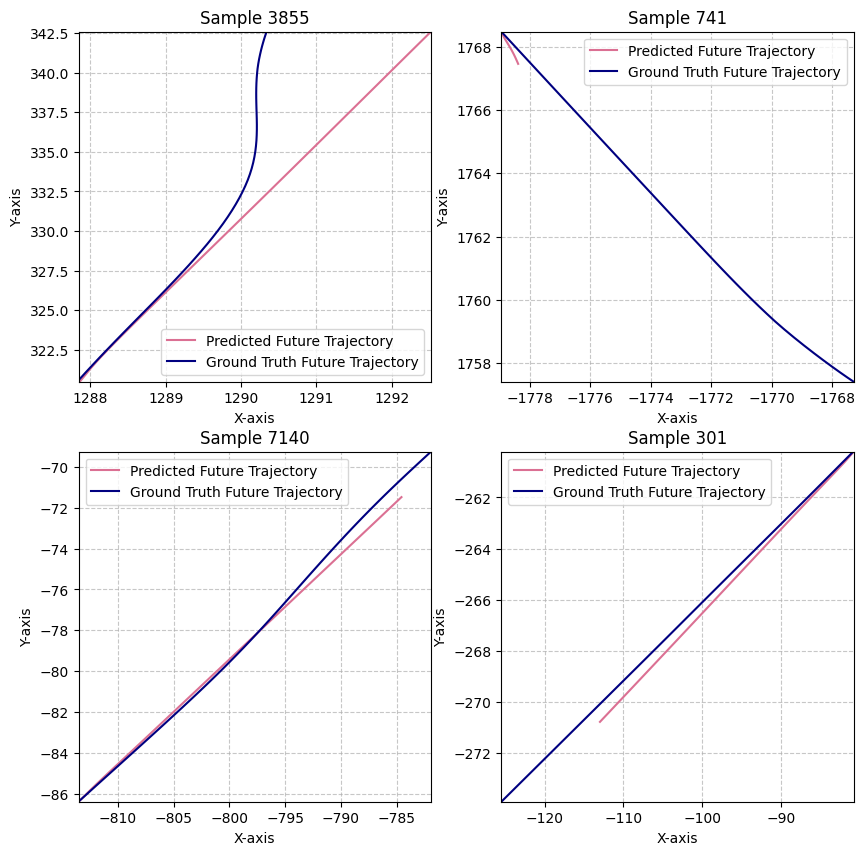

In [47]:
model = get_model()
if not isinstance(model, SceneContextModel):
    # LSTM can handle the timeseries data directly
    # TrajectoryDataset expects numpy arrays
    collate_func = lambda x: Batch.from_data_list(x)
    train_dataset = TrajectoryDatasetTrain(train_data, scale=scale, augment=True)
else:
    train_x: np.ndarray = train_data[..., :50, :]
    train_y: np.ndarray = train_data[:, 0, 50:, :2]
    X_train_tensor = torch.FloatTensor(train_x).reshape((-1, input_features))
    y_train_tensor = torch.FloatTensor(train_y).reshape((-1, output_features))
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)

visualize_predictions(model, train_dataset, "milestone_mlp_graph.png")